In [1]:
import torch 
import time 

print(torch.__version__)

dtype=torch.half
warm_up = 1000 
n_iter = 1000

fs = [] 
bs = []

for n in (1, 32, 64): 
    for c in (1, 32, 64): 
        for h in (14, 28, 56, 128, 256): 
            w = h
            for ks in (2, 3, 5, 7): 
                torch.cuda.empty_cache() 

                print(f'n {n}, c {c}, h {h}, w {w}, ks {ks}', end='\t')

                a = torch.randn(n, c, h, w, dtype=dtype, device='cuda').contiguous(memory_format=torch.channels_last)
                ref_a = a.clone().contiguous() 

                a.requires_grad_() 
                ref_a.requires_grad_() 

                pool = torch.nn.AvgPool2d(ks).cuda()
                ref_pool = torch.nn.AvgPool2d(ks).cuda()

                out = pool(a)
                ref_out = ref_pool(ref_a)

                grad = torch.ones_like(out)
                ref_grad = grad.clone().contiguous()
                
                out.backward(grad, retain_graph=True)
                ref_out.backward(ref_grad, retain_graph=True)

                assert((out==ref_out).all().item())
                assert((a.grad==ref_a.grad).all().item())

                ########## warm up ##########
                for _ in range(warm_up): 
                    out = pool(a)
                    ref_out = ref_pool(ref_a)
                    out.backward(grad, retain_graph=True)
                    ref_out.backward(grad, retain_graph=True)

                ########## channels_last forward 1 ##########
                torch.cuda.synchronize() 
                ts = time.time() 

                for _ in range(n_iter): 
                    out = pool(a)
                    torch.cuda.synchronize() 

                torch.cuda.synchronize() 
                t_channels_last_forward_1 = (time.time() - ts) / n_iter

                ########## contiguous forward ##########
                torch.cuda.synchronize()
                ts = time.time() 

                for _ in range(n_iter): 
                    ref_out = ref_pool(ref_a)
                    torch.cuda.synchronize() 

                torch.cuda.synchronize() 
                t_contiguous_forward = (time.time() - ts) / n_iter
                
                ########## channels_last forward 2 ##########
                torch.cuda.synchronize() 
                ts = time.time() 

                for _ in range(n_iter): 
                    out = pool(a)
                    torch.cuda.synchronize() 

                torch.cuda.synchronize() 
                t_channels_last_forward_2 = (time.time() - ts) / n_iter

                ########## channels_last backward 1 ##########
                torch.cuda.synchronize() 
                ts = time.time() 

                for _ in range(n_iter): 
                    out.backward(grad, retain_graph=True)
                    torch.cuda.synchronize() 

                torch.cuda.synchronize() 
                t_channels_last_backward_1 = (time.time() - ts) / n_iter

                ########## contiguous backward ##########
                torch.cuda.synchronize()
                ts = time.time() 

                for _ in range(n_iter): 
                    ref_out.backward(ref_grad, retain_graph=True)
                    torch.cuda.synchronize() 

                torch.cuda.synchronize() 
                t_contiguous_backward = (time.time() - ts) / n_iter
                
                ########## channels_last backward 2 ##########
                torch.cuda.synchronize() 
                ts = time.time() 

                for _ in range(n_iter): 
                    out.backward(grad, retain_graph=True)
                    torch.cuda.synchronize() 

                torch.cuda.synchronize() 
                t_channels_last_backward_2 = (time.time() - ts) / n_iter
                
                ########## stat ##########
                t_channels_last_forward = 0.5 * (t_channels_last_forward_1 + t_channels_last_forward_2)
                t_channels_last_backward = 0.5 * (t_channels_last_backward_1 + t_channels_last_backward_2)
                
                forward_speedup = t_contiguous_forward/t_channels_last_forward
                backward_speedup = t_contiguous_backward/t_channels_last_backward
                fs.append(forward_speedup)
                bs.append(backward_speedup)
                
                ########## print ##########
                print('channels_last speedup, forward {:.3f}, backward {:.3f}'.format(
                    forward_speedup, backward_speedup
                ))
                

1.6.0a0+64f5c4f
n 1, c 1, h 14, w 14, ks 2	channels_last speedup, forward 0.931, backward 1.039
n 1, c 1, h 14, w 14, ks 3	channels_last speedup, forward 0.954, backward 1.021
n 1, c 1, h 14, w 14, ks 5	channels_last speedup, forward 0.941, backward 1.026
n 1, c 1, h 14, w 14, ks 7	channels_last speedup, forward 0.955, backward 1.024
n 1, c 1, h 28, w 28, ks 2	channels_last speedup, forward 0.943, backward 1.047
n 1, c 1, h 28, w 28, ks 3	channels_last speedup, forward 0.931, backward 1.030
n 1, c 1, h 28, w 28, ks 5	channels_last speedup, forward 0.943, backward 1.033
n 1, c 1, h 28, w 28, ks 7	channels_last speedup, forward 0.965, backward 1.036
n 1, c 1, h 56, w 56, ks 2	channels_last speedup, forward 0.952, backward 1.028
n 1, c 1, h 56, w 56, ks 3	channels_last speedup, forward 0.895, backward 1.023
n 1, c 1, h 56, w 56, ks 5	channels_last speedup, forward 0.957, backward 1.023
n 1, c 1, h 56, w 56, ks 7	channels_last speedup, forward 0.950, backward 1.032
n 1, c 1, h 128, w 128, 

n 32, c 64, h 14, w 14, ks 2	channels_last speedup, forward 0.924, backward 0.992
n 32, c 64, h 14, w 14, ks 3	channels_last speedup, forward 0.925, backward 0.984
n 32, c 64, h 14, w 14, ks 5	channels_last speedup, forward 0.926, backward 0.963
n 32, c 64, h 14, w 14, ks 7	channels_last speedup, forward 0.930, backward 0.966
n 32, c 64, h 28, w 28, ks 2	channels_last speedup, forward 0.873, backward 0.834
n 32, c 64, h 28, w 28, ks 3	channels_last speedup, forward 0.931, backward 0.842
n 32, c 64, h 28, w 28, ks 5	channels_last speedup, forward 0.918, backward 0.825
n 32, c 64, h 28, w 28, ks 7	channels_last speedup, forward 0.924, backward 0.831
n 32, c 64, h 56, w 56, ks 2	channels_last speedup, forward 0.792, backward 0.808
n 32, c 64, h 56, w 56, ks 3	channels_last speedup, forward 0.857, backward 0.809
n 32, c 64, h 56, w 56, ks 5	channels_last speedup, forward 0.957, backward 0.810
n 32, c 64, h 56, w 56, ks 7	channels_last speedup, forward 0.983, backward 0.803
n 32, c 64, h 12

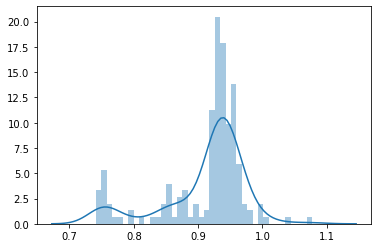

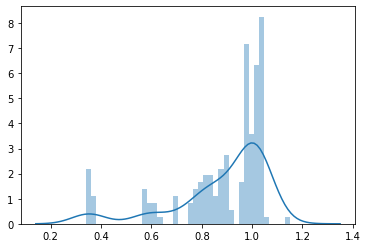

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.distplot(fs, bins=40)
plt.show() 

sns.distplot(bs, bins=40)
plt.show()